## Processing raw EEG data

+ Prepare EEG 
1. Subtract reference (mastoids)
2. Detrend 
3. Filter
4. Remove bad channels

+ Segment EEG into standard and deviant epochs (ERPs)
1. subtract baseline
2. Reject artefacts
3. Average (for each marker/subject/channel separately)

+ Calculate Mismatch response 
1. deviant - standard for a single subject, for example GiepST_D - GiepST_S
2. check differences between channels and subjects

#### Import Packages 

In [1]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autoreject import AutoReject # https://autoreject.github.io/stable/index.html
from multiprocessing import Pool

import PATH

from functions import dataset_loading
from functions import epodium

#### Load Data

In [2]:
dataset_raw, dataset_filenames = dataset_loading.load_dataset(PATH.ePod_dataset, preload=False)
events = dataset_loading.load_events(PATH.ePod_events, dataset_filenames)
events_12 = epodium.group_events_12(events)

epodium_metadata_filenames = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
epod_children, epod_cdi, epod_parents, epod_codes = \
    dataset_loading.load_metadata(PATH.ePod_metadata, epodium_metadata_filenames)

206 EEG files loaded
206 Event Marker files loaded
CPU times: user 3.71 s, sys: 704 ms, total: 4.41 s
Wall time: 5.02 s


In [7]:
print(len( os.listdir(PATH.ePod_dataset)))

208


#### Process ePodium dataset

In [ ]:


skip_files = ["107b (deel 1+2).bdf", "107b (deel 3+4).bdf", 
              "121a.bdf", "121b(1).bdf", "121b(2).bdf",
             "113a.bdf", "113b.bdf", "132a.bdf"] # 160a (2).bdf   160a.bdf
#  "145b.bdf"

# for each file in directory
#for file in os.listdir(PATH.ePod_dataset):
    
    
def process_file(file):    
    path = os.path.join(PATH.ePod_dataset, file)
    filename, extension = os.path.splitext(file)  
    
    if extension =='.bdf':
        path_processed = os.path.join(PATH.ePod_processed_autoreject, filename + ".npy")
        path_events = os.path.join(PATH.ePod_processed_autoreject, 'events', filename + ".txt")
        
        if os.path.exists(path_processed) and os.path.exists(path_events):
            print(f"File {file} already processed", end = '')
            return
        if file in skip_files: 
            return
            
        print(f"Processing file: {file}", end = '')        
        raw = mne.io.read_raw_bdf(path, preload = True, verbose = False)
        events = mne.find_events(raw, verbose = False)
        events_12 = epodium.group_events_12(events)
        
        # Set electrodes
        raw.pick_channels(epodium.channel_names)
        montage = mne.channels.make_standard_montage('standard_1020') 
        raw.info.set_montage(montage, on_missing = 'ignore')
        
        # High-pass filter for detrending
        raw.filter(0.1, None, verbose = False)
        # Create epochs from raw
        try:
            epochs = mne.Epochs(raw, events_12, epodium.event_dictionary, -0.2, 0.8, preload = True)
        except:
            print(f"Not all events in file {file}", end = '')
            return
        # Low pass filter for high-frequency artifacts
        epochs.filter(None, 40, verbose = False)
        
        # Reject bad trials and repair bad sensors in EEG
        ar = AutoReject()
        epochs_clean = ar.fit_transform(epochs)  
        
        # Save data and events
        np.save(path_processed, epochs_clean.get_data())        
        np.savetxt(path_events, epochs_clean.events, fmt='%i')

# Multiprocessing
pool = Pool(processes = 4)
pool.map(process_file, os.listdir(PATH.ePod_dataset))


File 110b.bdf already processedFile 124a.bdf already processedFile 116b.bdf already processedFile 105a.bdf already processed



File 105b.bdf already processedFile 125b.bdf already processedFile 112a.bdf already processedFile 118b.bdf already processed


File 127a.bdf already processedFile 117b.bdf already processed
File 107a.bdf already processedFile 112b.bdf already processed



File 125a.bdf already processedFile 106a.bdf already processedFile 118a.bdf already processedFile 111a.bdf already processed


File 120b.bdf already processed
File 106b.bdf already processedFile 114a.bdf already processed


File 119a.bdf already processedFile 127b.bdf already processed
File 114b.bdf already processedFile 109b.bdf already processed

File 120a.bdf already processed

File 123b.bdf already processedFile 115a.bdf already processedFile 126a.bdf already processed


File 123a.bdf already processedFile 115b.bdf already processed

File 128b.bdf already processedFile 109a.bdf already processed

File 117

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Processing file:  157b.bdf


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Processing file:  171b.bdf


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Processing file:  160b.bdf


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Processing file:  173b.bdf


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Processing file:  172b.bdf


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2387 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2387 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Processing file:  192b.bdf


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Processing file:  171a.bdf


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Processing file:  193b.bdf


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2387 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2387 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2387 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2387 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(






Estimated consensus=0.90 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/2387 [00:00<?,       ?it/s]

Dropped 5 epochs: 998, 1247, 1249, 1466, 1467
Processing file:  151b.bdf
Not setting metadata
2066 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2066 events and 2049 original time points ...
Dropped 715 epochs: 76, 80, 81, 82, 83, 88, 89, 90, 99, 113, 114, 118, 124, 128, 129, 130, 131, 132, 177, 178, 179, 180, 181, 182, 188, 201, 225, 226, 230, 234, 235, 236, 237, 239, 240, 241, 242, 244, 247, 249, 252, 253, 261, 262, 266, 273, 280, 288, 294, 306, 312, 373, 409, 410, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 498, 499, 502, 506, 509, 511, 518, 540

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Dropped 50 epochs: 110, 111, 112, 113, 114, 115, 130, 327, 336, 340, 409, 562, 614, 615, 678, 850, 891, 895, 896, 922, 934, 947, 949, 950, 951, 952, 953, 954, 956, 958, 967, 1060, 1061, 1062, 1065, 1067, 1068, 1087, 1221, 1315, 1369, 1371, 1373, 1377, 1378, 1379, 1697, 2080, 2099, 2100
Processing file:  220a.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2066 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2066 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2066 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2066 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/2066 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

Dropped 390 epochs: 5, 6, 12, 25, 32, 33, 35, 36, 55, 56, 57, 58, 59, 64, 65, 72, 124, 128, 132, 143, 145, 151, 154, 156, 157, 160, 161, 162, 164, 187, 197, 198, 203, 204, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 239, 252, 256, 295, 296, 297, 298, 343, 376, 380, 381, 386, 387, 388, 389, 396, 462, 467, 468, 469, 471, 472, 474, 475, 476, 477, 478, 480, 489, 493, 517, 529, 533, 541, 542, 564, 678, 698, 728, 757, 760, 777, 783, 805, 807, 808, 811, 841, 846, 850, 851, 853, 879, 890, 896, 902, 910, 911, 936, 940, 975, 978, 1043, 1068, 1111, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1124, 1126, 1127, 1129, 1133, 1134, 1135, 1136, 1137, 1139, 1140, 1141, 1145, 1146, 1150, 1151, 1152, 1155, 1158, 1159, 1164, 1168, 1169, 1175, 1177, 1181, 1207, 1263, 1268, 1320, 1321, 1331, 1359, 1360, 1367, 1368, 1373, 1391, 1411, 1412, 1415, 1430, 1431, 1433, 1442, 1443, 1445, 1446, 1449, 1

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Processing file:  151a.bdf


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Not all events in file 151a.bdf
Processing file:  154a.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Dropped 287 epochs: 32, 34, 35, 36, 43, 45, 55, 56, 57, 72, 73, 100, 142, 143, 145, 146, 147, 159, 233, 236, 237, 238, 239, 292, 293, 343, 344, 348, 349, 358, 380, 384, 385, 425, 433, 440, 441, 444, 445, 446, 449, 451, 452, 454, 455, 456, 467, 468, 469, 480, 481, 482, 495, 496, 563, 564, 571, 608, 623, 683, 693, 694, 712, 715, 730, 736, 741, 743, 745, 754, 755, 756, 757, 758, 759, 760, 761, 763, 768, 769, 770, 776, 818, 819, 821, 824, 825, 827, 828, 841, 842, 855, 867, 883, 885, 888, 889, 890, 898, 903, 935, 967, 968, 969, 1018, 1019, 1020, 1028, 1030, 1032, 1033, 1043, 1047, 1048, 1049, 1051, 1052, 1053, 1054, 1057, 1058, 1060, 1061, 1062, 1077, 1083, 1084, 1086, 1088, 1089, 1090, 1101, 1102, 1104, 1105, 1106, 1107, 1109, 1110, 1111, 1112, 1125, 1126, 1141, 1142, 1170, 1171, 1265, 1292, 1293, 1299, 1300, 1301, 1309, 1310, 1311, 1313, 1314, 1315, 1316, 1317, 1318, 1323, 1324, 1325, 1326, 1328, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1345, 1346, 1347, 1355, 1360, 1373, 1389, 1390, 139

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Dropped 689 epochs: 0, 27, 41, 46, 57, 58, 61, 62, 73, 76, 78, 83, 86, 89, 90, 120, 121, 123, 124, 126, 127, 128, 129, 130, 137, 138, 156, 184, 199, 200, 215, 220, 221, 223, 254, 257, 264, 270, 271, 272, 286, 287, 296, 339, 361, 380, 381, 382, 384, 385, 386, 387, 392, 393, 399, 401, 402, 405, 406, 407, 408, 409, 411, 412, 414, 416, 417, 419, 422, 425, 427, 448, 451, 452, 455, 456, 458, 461, 462, 463, 464, 465, 466, 468, 469, 500, 514, 516, 529, 530, 546, 547, 548, 549, 550, 561, 564, 572, 574, 577, 665, 666, 681, 682, 699, 700, 701, 703, 704, 706, 707, 775, 826, 837, 856, 858, 861, 862, 863, 864, 865, 873, 907, 908, 912, 913, 914, 915, 917, 918, 919, 920, 921, 922, 924, 927, 928, 929, 930, 932, 933, 934, 935, 936, 937, 938, 939, 942, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 956, 958, 959, 960, 961, 962, 964, 965, 966, 967, 968, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 991, 1005, 1021, 1022, 1030, 1035, 1041, 1042, 1044, 1046, 1048, 1064, 1083, 1084, 108

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2266 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2266 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2266 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

Dropped 23 epochs: 1, 16, 29, 289, 321, 322, 335, 336, 478, 479, 993, 1732, 1831, 2023, 2026, 2071, 2076, 2147, 2156, 2157, 2185, 2186, 2334
Processing file:  153b.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2266 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=1


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/2266 [00:00<?,       ?it/s]

Dropped 721 epochs: 51, 52, 56, 57, 58, 63, 68, 73, 81, 91, 92, 93, 94, 100, 101, 102, 105, 106, 108, 113, 114, 118, 120, 121, 137, 138, 139, 141, 143, 144, 147, 148, 176, 177, 178, 188, 197, 228, 236, 237, 238, 239, 240, 249, 263, 272, 273, 344, 364, 416, 417, 428, 429, 435, 438, 446, 448, 449, 453, 460, 462, 467, 468, 469, 477, 484, 485, 495, 502, 511, 516, 517, 518, 520, 522, 523, 524, 525, 526, 527, 528, 541, 544, 545, 546, 549, 550, 551, 552, 553, 554, 557, 558, 573, 575, 576, 580, 587, 588, 594, 595, 602, 604, 611, 621, 625, 664, 665, 666, 667, 668, 669, 670, 686, 690, 691, 692, 693, 707, 712, 713, 717, 721, 722, 723, 728, 731, 732, 735, 740, 741, 754, 755, 769, 791, 792, 799, 813, 815, 816, 817, 818, 819, 821, 822, 823, 824, 825, 826, 829, 830, 831, 832, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 851, 855, 857, 858, 859, 860, 861, 862, 865, 866, 867, 868, 869, 871, 884, 885, 886, 888, 889, 890, 891, 894, 895, 897, 898, 901, 903, 908, 909, 910, 918, 923, 926, 928

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(






Estimated consensus=0.90 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

Dropped 49 epochs: 2, 141, 190, 195, 196, 197, 198, 213, 236, 548, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 607, 608, 631, 796, 819, 826, 945, 998, 1083, 1084, 1480, 1507, 1524, 1527, 1531, 1532, 1534, 1554, 1559, 1713, 1821, 1822, 1823, 1824, 1829, 1892, 2425, 2434




Estimated consensus=1.00 and n_interpolate=31


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Processing file:  155b.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Dropped 9 epochs: 206, 207, 329, 330, 332, 907, 1071, 2091, 2092
Processing file:  187a.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Processing file:  101b.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.90 and n_interpolate=1


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Dropped 25 epochs: 293, 540, 541, 644, 692, 1001, 1133, 1621, 1653, 1657, 1658, 1666, 1687, 1693, 1759, 1760, 1797, 1856, 1859, 1924, 1925, 2046, 2047, 2092, 2348


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

Processing file:  153a.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Dropped 93 epochs: 2, 126, 127, 444, 445, 451, 537, 588, 612, 625, 723, 727, 728, 756, 860, 888, 889, 890, 892, 893, 894, 895, 896, 897, 898, 899, 927, 929, 945, 946, 947, 984, 993, 994, 995, 998, 1003, 1020, 1059, 1060, 1061, 1062, 1076, 1083, 1084, 1085, 1091, 1096, 1107, 1108, 1120, 1121, 1122, 1174, 1175, 1176, 1177, 1178, 1183, 1184, 1243, 1250, 1252, 1277, 1278, 1279, 1280, 1281, 1363, 1364, 1372, 1894, 2095, 2096, 2097, 2099, 2100, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2373, 2374, 2375, 2376, 2414, 2428, 2429, 2437, 2438
Processing file:  182a.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=1


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Dropped 261 epochs: 2, 12, 27, 45, 46, 47, 48, 50, 55, 60, 61, 66, 74, 153, 175, 203, 210, 289, 291, 308, 331, 363, 429, 430, 431, 433, 435, 439, 440, 441, 443, 458, 459, 465, 475, 476, 484, 487, 499, 507, 508, 509, 512, 513, 514, 515, 516, 517, 518, 521, 522, 525, 526, 538, 548, 549, 558, 562, 570, 595, 596, 600, 601, 602, 605, 607, 673, 691, 693, 694, 698, 722, 729, 733, 734, 743, 746, 759, 760, 761, 766, 767, 768, 769, 770, 771, 772, 773, 776, 777, 782, 783, 785, 792, 795, 817, 820, 827, 837, 848, 890, 899, 900, 901, 902, 943, 944, 952, 954, 956, 958, 963, 971, 972, 974, 975, 976, 979, 986, 1020, 1027, 1058, 1060, 1064, 1083, 1102, 1104, 1114, 1149, 1178, 1182, 1186, 1189, 1278, 1280, 1287, 1293, 1294, 1296, 1297, 1306, 1314, 1371, 1381, 1398, 1399, 1423, 1489, 1491, 1513, 1534, 1535, 1538, 1571, 1572, 1574, 1575, 1578, 1579, 1580, 1581, 1584, 1585, 1586, 1589, 1594, 1610, 1611, 1613, 1641, 1642, 1652, 1653, 1660, 1661, 1664, 1665, 1666, 1669, 1671, 1672, 1673, 1674, 1675, 1676, 167

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2315 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2315 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2315 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

Dropped 503 epochs: 24, 26, 31, 44, 45, 50, 62, 63, 65, 72, 104, 115, 116, 126, 165, 186, 187, 188, 193, 194, 195, 211, 212, 213, 214, 216, 219, 229, 231, 248, 252, 259, 265, 266, 271, 273, 276, 279, 280, 288, 294, 300, 301, 302, 304, 305, 314, 323, 324, 337, 339, 340, 345, 362, 367, 370, 378, 383, 389, 391, 392, 408, 409, 410, 454, 455, 457, 462, 463, 464, 469, 470, 474, 475, 476, 477, 482, 483, 494, 496, 498, 501, 504, 505, 506, 507, 508, 509, 510, 511, 516, 517, 521, 522, 523, 524, 525, 526, 527, 528, 529, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 542, 547, 548, 549, 550, 551, 553, 554, 555, 556, 557, 558, 559, 560, 561, 563, 564, 565, 567, 568, 569, 570, 571, 572, 573, 574, 575, 577, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 619, 620, 623, 624, 644, 648, 649, 653, 655, 656, 657, 670, 674, 696, 699, 746, 749, 750, 757, 758, 764, 765, 768, 769, 772, 773, 

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped




Estimated consensus=1.00 and n_interpolate=31


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2315 [00:00<?,       ?it/s]

Dropped 5 epochs: 91, 98, 99, 100, 1574
Processing file:  197a.bdf
Not setting metadata
2542 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2542 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2315 [00:00<?,       ?it/s]

Dropped 58 epochs: 166, 173, 175, 448, 451, 623, 624, 627, 631, 633, 638, 639, 640, 693, 798, 840, 972, 989, 995, 1100, 1253, 1346, 1348, 1349, 1415, 1447, 1452, 1453, 1466, 1499, 1597, 1598, 1599, 1646, 1657, 1658, 1663, 1664, 1665, 1668, 1669, 1916, 1971, 1972, 1983, 1994, 1996, 1998, 2000, 2011, 2014, 2059, 2060, 2062, 2202, 2221, 2233, 2267
Processing file:  102b.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2542 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2542 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Repairing epochs : 0/2542 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.90 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

Dropped 72 epochs: 479, 505, 575, 576, 577, 596, 597, 598, 599, 600, 1753, 1758, 1776, 1777, 1783, 1798, 1799, 1802, 1803, 1807, 1824, 1825, 1827, 1828, 1833, 1847, 1848, 1851, 1852, 1854, 1855, 1856, 1859, 1864, 1870, 1913, 1914, 1951, 1953, 1954, 1988, 2004, 2005, 2006, 2011, 2012, 2024, 2026, 2032, 2034, 2041, 2042, 2043, 2044, 2045, 2071, 2072, 2073, 2076, 2084, 2085, 2086, 2106, 2112, 2113, 2114, 2121, 2137, 2138, 2144, 2438, 2439
Processing file:  157a.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2542 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/f

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=31


  0%|          | Repairing epochs : 0/2542 [00:00<?,       ?it/s]

Dropped 3 epochs: 498, 757, 813
Processing file:  103a.bdf
Not setting metadata
2208 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2208 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Dropped 21 epochs: 308, 309, 310, 407, 408, 449, 452, 504, 505, 506, 998, 1075, 1092, 1305, 1306, 1601, 1793, 1954, 2109, 2458, 2459


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Processing file:  179b.bdf
Not setting metadata
2487 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2487 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2208 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2208 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2208 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2487 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2487 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2208 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=31


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.20 and n_interpolate=1


  0%|          | Repairing epochs : 0/2208 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 1371 epochs: 7, 8, 9, 10, 13, 16, 17, 31, 33, 34, 35, 36, 37, 38, 39, 40, 45, 48, 56, 60, 63, 64, 65, 70, 71, 72, 81, 82, 83, 84, 85, 86, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 165, 166, 167, 169, 170, 173, 179, 192, 193, 194, 195, 196, 197, 207, 208, 210, 211, 212, 217, 218, 222, 223, 226, 227, 235, 237, 239, 241, 242, 243, 244, 247, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 298, 299, 301, 304, 305, 306, 307, 310, 312, 313, 316, 317, 3

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2487 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2487 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/2487 [00:00<?,       ?it/s]

Dropped 457 epochs: 30, 31, 33, 34, 54, 58, 93, 94, 95, 99, 102, 116, 127, 128, 164, 184, 230, 238, 239, 251, 252, 256, 314, 331, 342, 344, 361, 370, 372, 387, 388, 497, 542, 543, 544, 547, 552, 559, 572, 573, 577, 579, 584, 585, 586, 587, 588, 589, 590, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 660, 661, 664, 671, 672, 677, 684, 742, 744, 763, 765, 774, 775, 801, 823, 828, 829, 839, 859, 896, 897, 898, 899, 900, 901, 917, 929, 931, 935, 958, 959, 960, 961, 962, 963, 964, 965, 966, 972, 995, 996, 1045, 1051, 1056, 1057, 1067, 1093, 1098, 1099, 1100, 1143, 1145, 1152, 1193, 1202, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1216, 1217, 1220, 1221, 1225, 1227, 1241, 1247, 1251, 1252, 1256, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1269, 1349, 1352, 1366, 1367, 1370, 1371, 1372, 1373, 1374, 1375, 1376,

/tmp/ipykernel_842265/3903065834.py:28: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(path, preload = True, verbose = False)


Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2389 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2389 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2389 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2389 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=1


  0%|          | Repairing epochs : 0/2389 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Dropped 346 epochs: 20, 30, 39, 40, 47, 48, 56, 63, 64, 65, 68, 69, 74, 75, 78, 86, 101, 117, 123, 158, 159, 181, 188, 189, 190, 193, 194, 195, 203, 220, 224, 270, 271, 273, 279, 284, 285, 286, 290, 291, 292, 295, 296, 298, 299, 300, 301, 302, 326, 327, 332, 334, 335, 336, 337, 338, 339, 344, 345, 346, 347, 348, 349, 350, 354, 356, 362, 363, 373, 380, 401, 407, 409, 418, 421, 429, 444, 472, 595, 610, 611, 621, 622, 623, 633, 637, 657, 658, 661, 662, 665, 668, 678, 680, 681, 682, 683, 685, 686, 687, 688, 689, 693, 694, 697, 698, 699, 700, 703, 704, 709, 719, 720, 726, 727, 742, 748, 753, 772, 773, 785, 786, 805, 821, 845, 853, 856, 889, 898, 899, 905, 911, 912, 913, 915, 916, 919, 920, 921, 922, 923, 924, 925, 926, 929, 930, 931, 932, 933, 934, 935, 936, 953, 966, 996, 1024, 1042, 1051, 1052, 1053, 1057, 1058, 1070, 1071, 1091, 1092, 1093, 1094, 1100, 1108, 1116, 1117, 1118, 1134, 1135, 1136, 1137, 1142, 1153, 1204, 1253, 1254, 1255, 1256, 1265, 1274, 1278, 1282, 1283, 1289, 1293, 1298,

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Dropped 106 epochs: 218, 219, 221, 222, 224, 225, 247, 273, 276, 277, 278, 338, 340, 373, 374, 400, 401, 402, 408, 409, 432, 433, 436, 437, 485, 486, 520, 573, 589, 609, 771, 772, 785, 786, 788, 795, 801, 809, 833, 850, 879, 892, 955, 956, 987, 1075, 1076, 1186, 1187, 1190, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1204, 1272, 1292, 1293, 1431, 1432, 1489, 1540, 1541, 1542, 1544, 1545, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1568, 1626, 1633, 1636, 1643, 1657, 1726, 1727, 1749, 1770, 1772, 1773, 2127, 2201, 2230, 2284, 2285, 2298, 2312, 2355
Processing file:  191b.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2521 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2521 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2521 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2521 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=1


  0%|          | Repairing epochs : 0/2521 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

Dropped 272 epochs: 0, 2, 6, 23, 61, 64, 65, 66, 68, 99, 100, 101, 102, 103, 106, 107, 109, 135, 136, 137, 138, 139, 140, 142, 155, 156, 173, 174, 195, 222, 285, 307, 357, 366, 368, 369, 370, 371, 383, 385, 406, 413, 421, 435, 451, 452, 481, 489, 490, 491, 492, 493, 498, 505, 506, 547, 549, 550, 551, 552, 553, 555, 556, 557, 558, 597, 615, 628, 629, 647, 661, 663, 664, 666, 667, 668, 669, 673, 675, 676, 677, 693, 697, 698, 699, 701, 702, 703, 704, 715, 736, 737, 738, 739, 740, 755, 774, 797, 798, 830, 832, 833, 853, 885, 905, 923, 924, 928, 931, 989, 990, 1013, 1016, 1018, 1019, 1033, 1034, 1060, 1067, 1072, 1084, 1102, 1105, 1116, 1130, 1133, 1181, 1182, 1183, 1184, 1188, 1222, 1292, 1293, 1295, 1296, 1301, 1303, 1305, 1306, 1307, 1316, 1364, 1367, 1373, 1405, 1423, 1458, 1484, 1485, 1508, 1524, 1525, 1528, 1529, 1648, 1649, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1691, 1692, 1693, 1714, 1719, 1726, 1727, 1729, 1730, 1768, 1774, 1810, 1811, 1812, 1813, 1823, 1824, 1870, 1873, 1874, 

  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped


  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

Dropped 61 epochs: 65, 77, 82, 110, 111, 169, 173, 398, 500, 502, 995, 1564, 1570, 1598, 1729, 1730, 1731, 2224, 2226, 2227, 2229, 2241, 2242, 2253, 2256, 2257, 2266, 2274, 2299, 2332, 2353, 2354, 2355, 2368, 2369, 2370, 2380, 2381, 2383, 2388, 2399, 2400, 2412, 2413, 2415, 2416, 2417, 2418, 2419, 2422, 2423, 2424, 2427, 2428, 2429, 2433, 2435, 2436, 2437, 2438, 2439
Processing file:  168b.bdf
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

/home/fpauwels/.local/lib/python3.8/site-packages/mne/bem.py:965: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

Dropped 147 epochs: 85, 99, 100, 109, 134, 149, 151, 174, 192, 237, 240, 264, 288, 391, 392, 393, 394, 395, 435, 617, 768, 789, 899, 1026, 1027, 1058, 1073, 1136, 1185, 1190, 1204, 1205, 1272, 1305, 1322, 1323, 1392, 1393, 1395, 1405, 1406, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1446, 1450, 1451, 1454, 1470, 1471, 1480, 1481, 1491, 1505, 1521, 1557, 1592, 1619, 1621, 1642, 1650, 1656, 1657, 1660, 1661, 1665, 1667, 1735, 1736, 1737, 1745, 1746, 1757, 1760, 1768, 1769, 1770, 1771, 1785, 1791, 1792, 1793, 1795, 1797, 1817, 1831, 1832, 1838, 1843, 1846, 1847, 1848, 1849, 1850, 1852, 1853, 1854, 1931, 1936, 1988, 1990, 2017, 2052, 2053, 2071, 2084, 2235, 2236, 2241, 2308, 2331, 2332, 2359, 2372, 2415
Processing file:  104b.bdf


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.90 and n_interpolate=4
Not setting metadata
2440 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2440 events and 2049 original time points ...


  0%|          | Repairing epochs : 0/2440 [00:00<?,       ?it/s]

0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/32 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/32 [00:00<?,       ?it/s]

Dropped 11 epochs: 12, 13, 14, 1225, 1226, 1229, 1230, 1333, 2056, 2057, 2058


# OLD:

In [15]:
# For each file...
filename_processed = os.path.join(PATH.processed, "ePod_autoreject", "file" + ".npy")
# filename_processed = os.path.join(PATH.ePod_processed_autoreject, "file" + ".npy")
np.save(filename_processed, epochs_clean.get_data())

In [ ]:
npy = np.load(filename_processed)

print(npy.shape)
print(epochs_clean.events)  

info = mne.create_info(epodium.channel_names, 2048, ch_types='eeg')

back_to_epochs = mne.EpochsArray(npy, info, events=epochs_clean.events, tmin=-0.2, event_id=epodium.event_dictionary)
back_to_epochs.info.set_montage(montage, on_missing = 'ignore')

evoked_D2 = back_to_epochs['GiepST_D'].average()
evoked_D2.plot(spatial_colors = True)

#### Interactive window
Interact with raw EEG data

Using matplotlib as 2D backend.
Opening raw-browser...


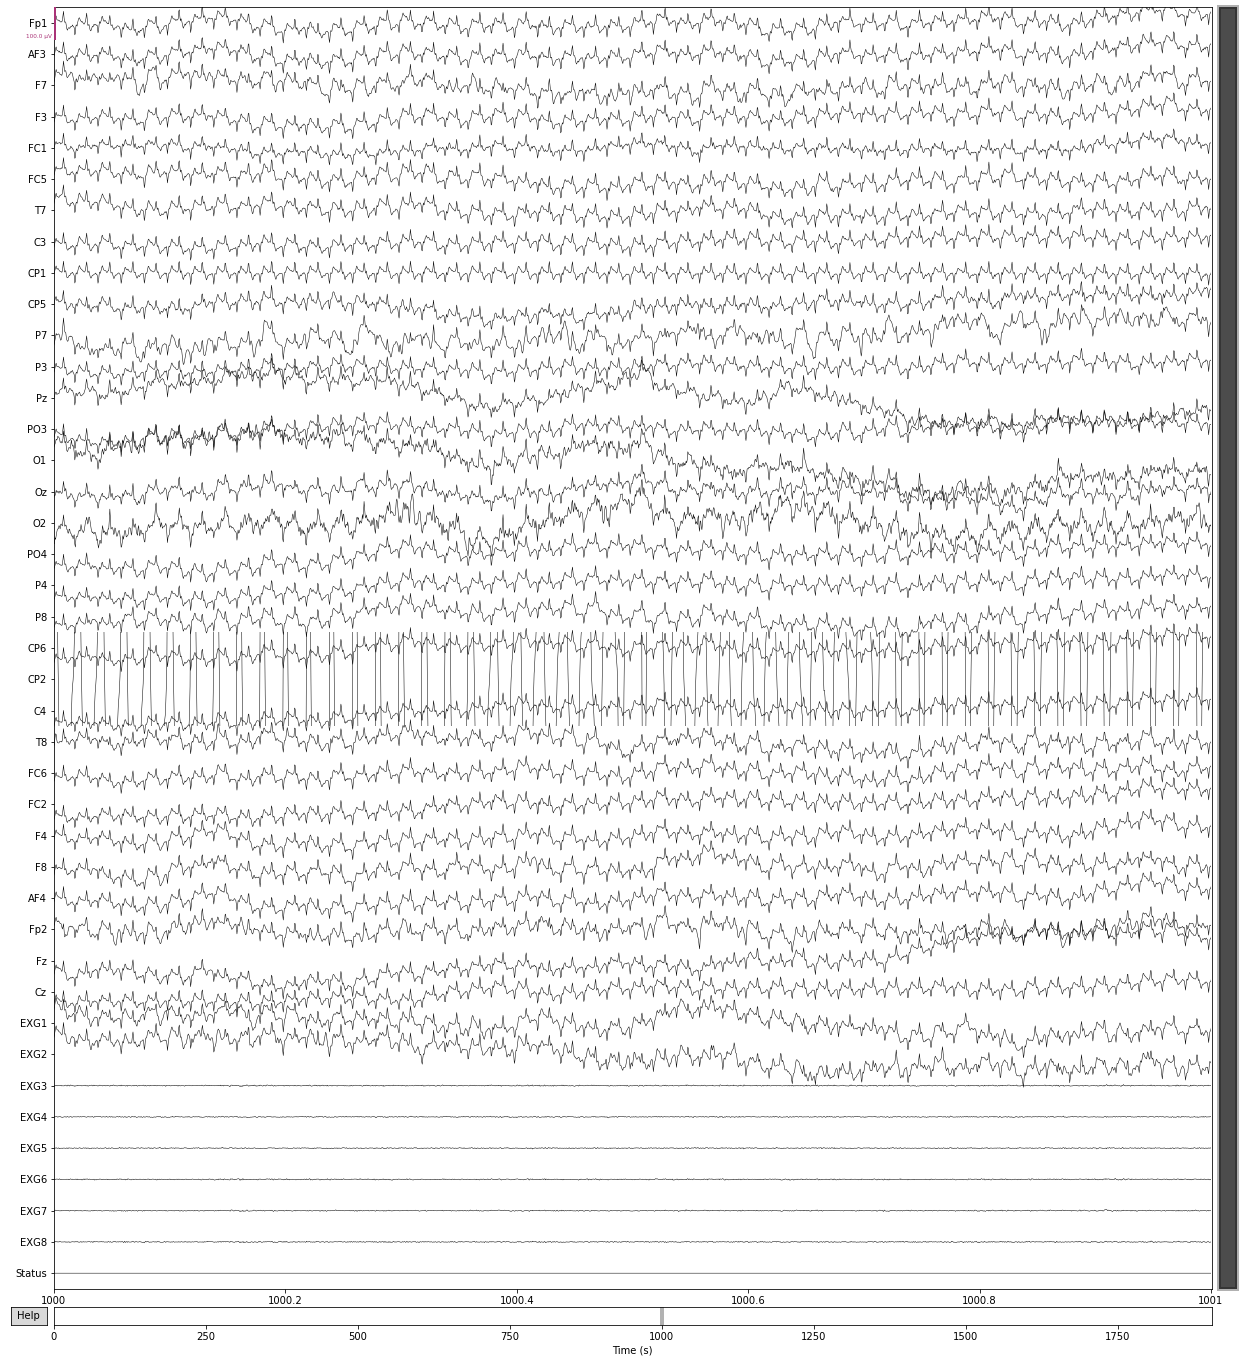

In [4]:
# %matplotlib qt / widget for external/internal interactive window (remove 'fig = ' if no figure shows) (try installing pip install PyQt5 if qt failed due to import binding)
# %matplotlib qt 
fig = mne.viz.plot_raw(epod_raw_preload[participant_index], events[participant_index], n_channels=50, scalings = 50e-6  ,duration = 1, start = 1000)

#### Prepare EEG 

+ Drop unused channels
+ Subtract reference (mastoids) 
+ Detrend 
+ Filter
+ Remove bad channels

epod_raw_preload is used, since some functionalities require preloaded data.


#### Segment EEG into standard and deviant epochs 
+ subtract baseline
+ Reject artefacts
+ Average to get ERPs (for each subject, event, and channel separately))

#### Calculate Mismatch response 
Deviant minus (-) standard 

Check between subjects to see if the subjects have similar responses

Check between channels to observe which parts of the brain are more influenced by the events


#### Extract features 
+ peak latency
+ peak amplitude
+ mean amplitude


#### Create fitting labels


#### Input data into DL models

+ Input data X has dimensions: (subjects, trials, samples, channels)
+ Label data Y has dimensons: (subjects, trials, classes)

#### Visualise results